# Coding: Language Model based on LSTM

 - Dataset: WikiText-2
 - Model: LSTM/GRU
 - Optimizer: Adam
 - Learning Rate: 0.001
 - Batch Size: 64
 - Epochs: 10
 - Dropout: 0.2

In [1]:
# Load WikiText-2 Dataset using Hugging Face datasets

import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from collections import Counter
import re

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load WikiText-2 dataset from Hugging Face
print("Loading WikiText-2 dataset from Hugging Face...")
dataset = load_dataset("wikitext", "wikitext-2-v1")

# Access the splits
train_dataset = dataset['train']
val_dataset = dataset['validation']
test_dataset = dataset['test']

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# Show a sample
# Find a non-empty sample
print(f"\nLooking for non-empty samples...")
sample_text = None
for i, example in enumerate(train_dataset):
    if example['text'].strip():  # Find first non-empty line
        sample_text = example['text']
        print(f"Found non-empty sample at index {i}")
        break
print(f"First sample: {sample_text[:200]}")

# Basic tokenization function
def basic_tokenize(text):
    # Convert to lowercase and split on whitespace and punctuation
    text = text.lower()
    tokens = re.findall(r'\b\w+\b', text)
    return tokens

# Build vocabulary from training data
print("\nBuilding vocabulary...")
all_tokens = []
non_empty_lines = 0
for example in train_dataset:
    if example['text'].strip():  # Skip empty lines
        tokens = basic_tokenize(example['text'])
        all_tokens.extend(tokens)
        non_empty_lines += 1

# Create vocabulary
vocab_counter = Counter(all_tokens)
vocab_size = len(vocab_counter)
print(f"Non-empty lines: {non_empty_lines}")
print(f"Total tokens: {len(all_tokens)}")
print(f"Vocabulary size: {vocab_size}")

# Create word to index mapping
vocab = {'<unk>': 0, '<pad>': 1}
for word, count in vocab_counter.most_common():
    if word not in vocab:
        vocab[word] = len(vocab)

# Create index to word mapping
idx_to_word = {idx: word for word, idx in vocab.items()}

print(f"Final vocabulary size (with special tokens): {len(vocab)}")
print(f"Most common words: {list(vocab_counter.most_common(10))}")

# Function to convert text to indices
def text_to_indices(text, vocab):
    tokens = basic_tokenize(text)
    return [vocab.get(token, vocab['<unk>']) for token in tokens]

# Convert a sample to see the tokenization
sample_indices = text_to_indices(sample_text, vocab)
print(f"\nSample tokenization:")
print(f"Original: {sample_text[:100]}")
print(f"Tokens: {basic_tokenize(sample_text)[:20]}")
print(f"Indices: {sample_indices[:20]}")

print("\nDataset loaded successfully!")

Using device: cuda
Loading WikiText-2 dataset from Hugging Face...


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/685k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/6.07M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/618k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Train dataset size: 36718
Validation dataset size: 3760
Test dataset size: 4358

Looking for non-empty samples...
Found non-empty sample at index 1
First sample:  = Valkyria Chronicles III = 


Building vocabulary...
Non-empty lines: 23767
Total tokens: 1750345
Vocabulary size: 28710
Final vocabulary size (with special tokens): 28712
Most common words: [('the', 130768), ('of', 57030), ('unk', 54625), ('and', 50735), ('in', 45015), ('to', 39521), ('a', 36523), ('was', 21008), ('on', 15140), ('as', 15058)]

Sample tokenization:
Original:  = Valkyria Chronicles III = 

Tokens: ['valkyria', 'chronicles', 'iii']
Indices: [3767, 3830, 860]

Dataset loaded successfully!


In [2]:
# Data Preprocess & Init DataLoader

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class WikiTextDataset(Dataset):
    def __init__(self, hf_dataset, vocab, sequence_length=50):
        """
        Custom Dataset for WikiText-2
        
        Args:
            hf_dataset: Hugging Face dataset split
            vocab: vocabulary dictionary
            sequence_length: length of input sequences
        """
        self.vocab = vocab
        self.sequence_length = sequence_length
        
        # Process all text and create sequences
        self.sequences = []
        self.targets = []
        
        print(f"Processing dataset with sequence length: {sequence_length}")
        
        # Concatenate all non-empty text and tokenize
        all_indices = []
        for example in hf_dataset:
            if example['text'].strip():  # Skip empty lines
                indices = text_to_indices(example['text'], vocab)
                all_indices.extend(indices)
        
        print(f"Total tokens in dataset: {len(all_indices)}")
        
        # Create sequences of specified length
        for i in range(len(all_indices) - sequence_length):
            # Input sequence
            seq = all_indices[i:i + sequence_length]
            # Target is the next token
            target = all_indices[i + sequence_length]
            
            self.sequences.append(seq)
            self.targets.append(target)
        
        print(f"Created {len(self.sequences)} sequences")
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.sequences[idx], dtype=torch.long),
            torch.tensor(self.targets[idx], dtype=torch.long)
        )

# Create datasets
sequence_length = 50
batch_size = 64

print("Creating training dataset...")
train_wiki_dataset = WikiTextDataset(train_dataset, vocab, sequence_length)

print("\nCreating validation dataset...")
val_wiki_dataset = WikiTextDataset(val_dataset, vocab, sequence_length)

print("\nCreating test dataset...")
test_wiki_dataset = WikiTextDataset(test_dataset, vocab, sequence_length)

# Create DataLoaders
train_loader = DataLoader(
    train_wiki_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    num_workers=0  # Set to 0 for compatibility
)

val_loader = DataLoader(
    val_wiki_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)

test_loader = DataLoader(
    test_wiki_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    num_workers=0
)

print(f"\nDataLoader Summary:")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"Batch size: {batch_size}")
print(f"Sequence length: {sequence_length}")

# Test the DataLoader
print("\nTesting DataLoader...")
for batch_idx, (sequences, targets) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:")
    print(f"  Sequences shape: {sequences.shape}")
    print(f"  Targets shape: {targets.shape}")
    print(f"  Sample sequence: {sequences[0][:10].tolist()}")
    print(f"  Sample target: {targets[0].item()}")
    
    # Convert back to words for verification
    sample_words = [idx_to_word[idx.item()] for idx in sequences[0]]
    target_word = idx_to_word[targets[0].item()]
    print(f"  Sample words: {sample_words}")
    print(f"  Target word: {target_word}")
    break  # Only show first batch

print("\nDataLoader created successfully!")

Creating training dataset...
Processing dataset with sequence length: 50
Total tokens in dataset: 1750345
Created 1750295 sequences

Creating validation dataset...
Processing dataset with sequence length: 50
Total tokens in dataset: 183606
Created 183556 sequences

Creating test dataset...
Processing dataset with sequence length: 50
Total tokens in dataset: 206381
Created 206331 sequences

DataLoader Summary:
Training batches: 27349
Validation batches: 2869
Test batches: 3224
Batch size: 64
Sequence length: 50

Testing DataLoader...
Batch 1:
  Sequences shape: torch.Size([64, 50])
  Targets shape: torch.Size([64])
  Sample sequence: [4069, 402, 1436, 755, 3324, 178, 413, 686, 198, 8]
  Sample target: 2
  Sample words: ['hawaii', 'reported', '70', 'mph', '110', 'km', 'h', 'winds', 'within', 'a', 'storm', 'prompting', 'the', 'jtwc', 'to', 'initiate', 'advisories', 'on', 'tropical', 'storm', 'dot', 'despite', 'an', 'apparent', 'correlation', 'between', 'dot', 'and', 'the', 'preceding', 'u

In [3]:
# GRU Language Model Implementation

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import math

class GRULanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=512, num_layers=2, dropout=0.2):
        """
        GRU-based Language Model for next word prediction
        
        Args:
            vocab_size: Size of vocabulary
            embedding_dim: Dimension of word embeddings
            hidden_dim: Hidden dimension of GRU
            num_layers: Number of GRU layers
            dropout: Dropout probability
        """
        super(GRULanguageModel, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        
        # Word embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # GRU layer(s)
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        
        # Dropout layer
        self.dropout_layer = nn.Dropout(dropout)
        
        # Output projection layer
        self.output_projection = nn.Linear(hidden_dim, vocab_size)
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        """Initialize model weights"""
        # Initialize embedding weights
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        
        # Initialize GRU weights
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)
        
        # Initialize output layer
        nn.init.xavier_uniform_(self.output_projection.weight)
        nn.init.zeros_(self.output_projection.bias)
    
    def forward(self, input_ids, hidden=None):
        """
        Forward pass
        
        Args:
            input_ids: Input token indices [batch_size, seq_len]
            hidden: Hidden state from previous step
            
        Returns:
            logits: Output logits [batch_size, seq_len, vocab_size]
            hidden: Final hidden state
        """
        batch_size, seq_len = input_ids.size()
        
        # Word embeddings
        embeddings = self.embedding(input_ids)  # [batch_size, seq_len, embedding_dim]
        
        # GRU forward pass, 2 layers by default
        gru_output, hidden = self.gru(embeddings, hidden)  # [batch_size, seq_len, hidden_dim]
        
        # Apply dropout to GRU output
        gru_output = self.dropout_layer(gru_output)
        
        # Project to vocabulary size
        logits = self.output_projection(gru_output)  # [batch_size, seq_len, vocab_size]
        
        return logits, hidden
    
    def init_hidden(self, batch_size):
        """Initialize hidden state"""
        return torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(next(self.parameters()).device)

# Model hyperparameters
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
dropout = 0.2
learning_rate = 0.0001

# Initialize model
model = GRULanguageModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    dropout=dropout
)

# Move model to device
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])  # Ignore padding tokens
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# Should try LR-Scheduler? If you use it, make the initial LR=0.001
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=2)

# Print model information
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nGRU Language Model Summary:")
print(f"Vocabulary size: {vocab_size:,}")
print(f"Embedding dimension: {embedding_dim}")
print(f"Hidden dimension: {hidden_dim}")
print(f"Number of layers: {num_layers}")
print(f"Dropout: {dropout}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model device: {next(model.parameters()).device}")

# Test the model with a sample batch
print(f"\nTesting model with sample batch...")
model.eval()
with torch.no_grad():
    # Get a sample batch
    sample_sequences, sample_targets = next(iter(train_loader))
    sample_sequences = sample_sequences.to(device)
    sample_targets = sample_targets.to(device)
    
    # Forward pass
    logits, hidden = model(sample_sequences)
    
    print(f"Input shape: {sample_sequences.shape}")
    print(f"Output logits shape: {logits.shape}")
    print(f"Hidden state shape: {hidden.shape}")
    print(f"Target shape: {sample_targets.shape}")
    
    # Calculate loss for the last token prediction
    last_token_logits = logits[:, -1, :]  # [batch_size, vocab_size]
    loss = criterion(last_token_logits, sample_targets)
    print(f"Sample loss: {loss.item():.4f}")
    
    # Get predictions
    predictions = torch.argmax(last_token_logits, dim=-1)
    accuracy = (predictions == sample_targets).float().mean()
    print(f"Sample accuracy: {accuracy.item():.4f}")

print(f"\nModel initialized successfully!")


GRU Language Model Summary:
Vocabulary size: 28,712
Embedding dimension: 128
Hidden dimension: 256
Number of layers: 2
Dropout: 0.2
Total parameters: 11,745,320
Trainable parameters: 11,745,320
Model device: cuda:0

Testing model with sample batch...
Input shape: torch.Size([64, 50])
Output logits shape: torch.Size([64, 50, 28712])
Hidden state shape: torch.Size([2, 64, 256])
Target shape: torch.Size([64])
Sample loss: 10.2650
Sample accuracy: 0.0000

Model initialized successfully!


🚀 Starting GRU Language Model Training...
Model has 11,745,320 parameters
Starting training for 10 epochs...
Training batches: 27349
Validation batches: 2869
------------------------------------------------------------


Epoch 1 Training:   4%|▎         | 1011/27349 [00:12<05:13, 83.90it/s, Loss=7.7516, Acc=0.0735]


Batch 1000/27349:
  Loss: 7.7534
  Accuracy: 0.0737


Epoch 1 Training:   7%|▋         | 2011/27349 [00:24<04:44, 89.07it/s, Loss=7.5865, Acc=0.0739]


Batch 2000/27349:
  Loss: 7.5885
  Accuracy: 0.0740


Epoch 1 Training:  11%|█         | 3007/27349 [00:37<05:36, 72.38it/s, Loss=7.5024, Acc=0.0770]


Batch 3000/27349:
  Loss: 7.5036
  Accuracy: 0.0770


Epoch 1 Training:  15%|█▍        | 4012/27349 [00:50<04:48, 80.94it/s, Loss=7.4338, Acc=0.0805]


Batch 4000/27349:
  Loss: 7.4336
  Accuracy: 0.0805


Epoch 1 Training:  18%|█▊        | 5014/27349 [01:02<05:16, 70.61it/s, Loss=7.3793, Acc=0.0832]


Batch 5000/27349:
  Loss: 7.3798
  Accuracy: 0.0832


Epoch 1 Training:  22%|██▏       | 6008/27349 [01:16<04:49, 73.84it/s, Loss=7.3384, Acc=0.0851]


Batch 6000/27349:
  Loss: 7.3388
  Accuracy: 0.0851


Epoch 1 Training:  26%|██▌       | 7008/27349 [01:30<04:48, 70.54it/s, Loss=7.3072, Acc=0.0864]


Batch 7000/27349:
  Loss: 7.3071
  Accuracy: 0.0864


Epoch 1 Training:  29%|██▉       | 8014/27349 [01:44<03:50, 83.87it/s, Loss=7.2775, Acc=0.0879]


Batch 8000/27349:
  Loss: 7.2781
  Accuracy: 0.0878


Epoch 1 Training:  33%|███▎      | 9008/27349 [01:57<04:04, 74.91it/s, Loss=7.2532, Acc=0.0894]


Batch 9000/27349:
  Loss: 7.2535
  Accuracy: 0.0894


Epoch 1 Training:  37%|███▋      | 10008/27349 [02:10<03:50, 75.19it/s, Loss=7.2320, Acc=0.0907]


Batch 10000/27349:
  Loss: 7.2323
  Accuracy: 0.0907


Epoch 1 Training:  40%|████      | 11008/27349 [02:23<03:39, 74.60it/s, Loss=7.2109, Acc=0.0921]


Batch 11000/27349:
  Loss: 7.2110
  Accuracy: 0.0921


Epoch 1 Training:  44%|████▍     | 12008/27349 [02:37<03:24, 74.85it/s, Loss=7.1923, Acc=0.0933]


Batch 12000/27349:
  Loss: 7.1928
  Accuracy: 0.0932


Epoch 1 Training:  48%|████▊     | 13008/27349 [02:50<03:27, 69.27it/s, Loss=7.1754, Acc=0.0945]


Batch 13000/27349:
  Loss: 7.1756
  Accuracy: 0.0945


Epoch 1 Training:  51%|█████     | 14009/27349 [03:04<03:07, 71.09it/s, Loss=7.1578, Acc=0.0956]


Batch 14000/27349:
  Loss: 7.1582
  Accuracy: 0.0956


Epoch 1 Training:  55%|█████▍    | 15014/27349 [03:18<02:48, 73.33it/s, Loss=7.1409, Acc=0.0968]


Batch 15000/27349:
  Loss: 7.1411
  Accuracy: 0.0968


Epoch 1 Training:  59%|█████▊    | 16011/27349 [03:32<02:32, 74.43it/s, Loss=7.1233, Acc=0.0979]


Batch 16000/27349:
  Loss: 7.1236
  Accuracy: 0.0979


Epoch 1 Training:  62%|██████▏   | 17011/27349 [03:46<02:22, 72.31it/s, Loss=7.1085, Acc=0.0990]


Batch 17000/27349:
  Loss: 7.1086
  Accuracy: 0.0989


Epoch 1 Training:  66%|██████▌   | 18015/27349 [03:59<01:49, 85.10it/s, Loss=7.0932, Acc=0.1001]


Batch 18000/27349:
  Loss: 7.0934
  Accuracy: 0.1000


Epoch 1 Training:  70%|██████▉   | 19009/27349 [04:11<01:54, 73.00it/s, Loss=7.0786, Acc=0.1010]


Batch 19000/27349:
  Loss: 7.0787
  Accuracy: 0.1010


Epoch 1 Training:  73%|███████▎  | 20008/27349 [04:23<01:40, 73.39it/s, Loss=7.0658, Acc=0.1019]


Batch 20000/27349:
  Loss: 7.0660
  Accuracy: 0.1019


Epoch 1 Training:  77%|███████▋  | 21007/27349 [04:37<01:29, 70.96it/s, Loss=7.0528, Acc=0.1028]


Batch 21000/27349:
  Loss: 7.0529
  Accuracy: 0.1028


Epoch 1 Training:  80%|████████  | 22014/27349 [04:51<01:07, 79.16it/s, Loss=7.0400, Acc=0.1037]


Batch 22000/27349:
  Loss: 7.0401
  Accuracy: 0.1037


Epoch 1 Training:  84%|████████▍ | 23010/27349 [05:02<00:52, 83.12it/s, Loss=7.0274, Acc=0.1047]


Batch 23000/27349:
  Loss: 7.0276
  Accuracy: 0.1047


Epoch 1 Training:  88%|████████▊ | 24009/27349 [05:14<00:38, 85.65it/s, Loss=7.0157, Acc=0.1055]


Batch 24000/27349:
  Loss: 7.0159
  Accuracy: 0.1055


Epoch 1 Training:  91%|█████████▏| 25012/27349 [05:28<00:30, 76.66it/s, Loss=7.0037, Acc=0.1064]


Batch 25000/27349:
  Loss: 7.0040
  Accuracy: 0.1064


Epoch 1 Training:  95%|█████████▌| 26007/27349 [05:42<00:18, 70.64it/s, Loss=6.9918, Acc=0.1074]


Batch 26000/27349:
  Loss: 6.9920
  Accuracy: 0.1074


Epoch 1 Training:  99%|█████████▉| 27008/27349 [05:56<00:04, 71.73it/s, Loss=6.9811, Acc=0.1082]


Batch 27000/27349:
  Loss: 6.9813
  Accuracy: 0.1081


Epoch 1 Validation: 100%|██████████| 2869/2869 [00:13<00:00, 213.55it/s, Val Loss=6.3928, Val Acc=0.1412]


✓ New best model saved! Val Loss: 6.3928

Epoch 1/10 Summary:
  Train Loss: 6.9776 | Train Acc: 0.1084
  Val Loss: 6.3928 | Val Acc: 0.1412
  Time: 374.66s
------------------------------------------------------------


Epoch 2 Training:   4%|▎         | 1015/27349 [00:13<04:58, 88.15it/s, Loss=6.5892, Acc=0.1336]


Batch 1000/27349:
  Loss: 6.5877
  Accuracy: 0.1337


Epoch 2 Training:   7%|▋         | 2017/27349 [00:24<04:48, 87.76it/s, Loss=6.6029, Acc=0.1326]


Batch 2000/27349:
  Loss: 6.6032
  Accuracy: 0.1326


Epoch 2 Training:  11%|█         | 3011/27349 [00:36<04:53, 82.94it/s, Loss=6.6037, Acc=0.1328]


Batch 3000/27349:
  Loss: 6.6046
  Accuracy: 0.1328


Epoch 2 Training:  15%|█▍        | 4013/27349 [00:49<05:23, 72.11it/s, Loss=6.6030, Acc=0.1332]


Batch 4000/27349:
  Loss: 6.6037
  Accuracy: 0.1332


Epoch 2 Training:  18%|█▊        | 5007/27349 [01:03<05:05, 73.02it/s, Loss=6.5925, Acc=0.1341]


Batch 5000/27349:
  Loss: 6.5924
  Accuracy: 0.1341


Epoch 2 Training:  22%|██▏       | 6008/27349 [01:17<04:51, 73.29it/s, Loss=6.5870, Acc=0.1341]


Batch 6000/27349:
  Loss: 6.5870
  Accuracy: 0.1341


Epoch 2 Training:  26%|██▌       | 7009/27349 [01:30<03:55, 86.24it/s, Loss=6.5835, Acc=0.1342]


Batch 7000/27349:
  Loss: 6.5833
  Accuracy: 0.1342


Epoch 2 Training:  29%|██▉       | 8017/27349 [01:42<03:42, 86.83it/s, Loss=6.5813, Acc=0.1344]


Batch 8000/27349:
  Loss: 6.5812
  Accuracy: 0.1344


Epoch 2 Training:  33%|███▎      | 9011/27349 [01:54<03:45, 81.30it/s, Loss=6.5784, Acc=0.1346]


Batch 9000/27349:
  Loss: 6.5784
  Accuracy: 0.1346


Epoch 2 Training:  37%|███▋      | 10015/27349 [02:06<03:25, 84.26it/s, Loss=6.5757, Acc=0.1349]


Batch 10000/27349:
  Loss: 6.5757
  Accuracy: 0.1349


Epoch 2 Training:  40%|████      | 11010/27349 [02:19<03:37, 75.02it/s, Loss=6.5755, Acc=0.1352]


Batch 11000/27349:
  Loss: 6.5756
  Accuracy: 0.1352


Epoch 2 Training:  44%|████▍     | 12013/27349 [02:33<03:36, 70.77it/s, Loss=6.5710, Acc=0.1356]


Batch 12000/27349:
  Loss: 6.5712
  Accuracy: 0.1356


Epoch 2 Training:  48%|████▊     | 13012/27349 [02:47<03:25, 69.80it/s, Loss=6.5667, Acc=0.1358]


Batch 13000/27349:
  Loss: 6.5670
  Accuracy: 0.1358


Epoch 2 Training:  51%|█████     | 14011/27349 [03:01<03:07, 71.19it/s, Loss=6.5621, Acc=0.1362]


Batch 14000/27349:
  Loss: 6.5621
  Accuracy: 0.1361


Epoch 2 Training:  55%|█████▍    | 15014/27349 [03:14<02:21, 86.87it/s, Loss=6.5578, Acc=0.1364]


Batch 15000/27349:
  Loss: 6.5579
  Accuracy: 0.1364


Epoch 2 Training:  59%|█████▊    | 16013/27349 [03:25<02:11, 85.91it/s, Loss=6.5554, Acc=0.1367]


Batch 16000/27349:
  Loss: 6.5555
  Accuracy: 0.1367


Epoch 2 Training:  62%|██████▏   | 17012/27349 [03:37<01:59, 86.54it/s, Loss=6.5510, Acc=0.1369]


Batch 17000/27349:
  Loss: 6.5512
  Accuracy: 0.1369


Epoch 2 Training:  66%|██████▌   | 18011/27349 [03:49<01:55, 81.02it/s, Loss=6.5458, Acc=0.1373]


Batch 18000/27349:
  Loss: 6.5458
  Accuracy: 0.1373


Epoch 2 Training:  70%|██████▉   | 19010/27349 [04:01<01:41, 82.19it/s, Loss=6.5426, Acc=0.1375]


Batch 19000/27349:
  Loss: 6.5427
  Accuracy: 0.1375


Epoch 2 Training:  73%|███████▎  | 20014/27349 [04:13<01:27, 83.74it/s, Loss=6.5384, Acc=0.1378]


Batch 20000/27349:
  Loss: 6.5383
  Accuracy: 0.1378


Epoch 2 Training:  77%|███████▋  | 21016/27349 [04:26<01:11, 88.47it/s, Loss=6.5342, Acc=0.1381]


Batch 21000/27349:
  Loss: 6.5343
  Accuracy: 0.1381


Epoch 2 Training:  81%|████████  | 22016/27349 [04:38<01:03, 84.09it/s, Loss=6.5297, Acc=0.1383]


Batch 22000/27349:
  Loss: 6.5297
  Accuracy: 0.1383


Epoch 2 Training:  84%|████████▍ | 23015/27349 [04:50<00:53, 80.69it/s, Loss=6.5256, Acc=0.1385]


Batch 23000/27349:
  Loss: 6.5257
  Accuracy: 0.1385


Epoch 2 Training:  88%|████████▊ | 24010/27349 [05:03<00:37, 89.37it/s, Loss=6.5226, Acc=0.1388]


Batch 24000/27349:
  Loss: 6.5225
  Accuracy: 0.1388


Epoch 2 Training:  91%|█████████▏| 25009/27349 [05:15<00:28, 82.97it/s, Loss=6.5187, Acc=0.1390]


Batch 25000/27349:
  Loss: 6.5187
  Accuracy: 0.1390


Epoch 2 Training:  95%|█████████▌| 26011/27349 [05:29<00:15, 86.46it/s, Loss=6.5146, Acc=0.1392]


Batch 26000/27349:
  Loss: 6.5148
  Accuracy: 0.1392


Epoch 2 Training:  99%|█████████▉| 27013/27349 [05:41<00:03, 84.35it/s, Loss=6.5117, Acc=0.1394]


Batch 27000/27349:
  Loss: 6.5117
  Accuracy: 0.1394


Epoch 2 Validation: 100%|██████████| 2869/2869 [00:13<00:00, 217.27it/s, Val Loss=6.1653, Val Acc=0.1556]


✓ New best model saved! Val Loss: 6.1653

Epoch 2/10 Summary:
  Train Loss: 6.5107 | Train Acc: 0.1394
  Val Loss: 6.1653 | Val Acc: 0.1556
  Time: 358.29s
------------------------------------------------------------


Epoch 3 Training:   4%|▎         | 1008/27349 [00:11<05:09, 85.08it/s, Loss=6.3332, Acc=0.1485]


Batch 1000/27349:
  Loss: 6.3346
  Accuracy: 0.1485


Epoch 3 Training:   7%|▋         | 2016/27349 [00:23<05:02, 83.86it/s, Loss=6.3267, Acc=0.1477]


Batch 2000/27349:
  Loss: 6.3273
  Accuracy: 0.1476


Epoch 3 Training:  11%|█         | 3015/27349 [00:35<04:37, 87.60it/s, Loss=6.3264, Acc=0.1480]


Batch 3000/27349:
  Loss: 6.3264
  Accuracy: 0.1479


Epoch 3 Training:  15%|█▍        | 4011/27349 [00:47<04:42, 82.67it/s, Loss=6.3222, Acc=0.1483]


Batch 4000/27349:
  Loss: 6.3228
  Accuracy: 0.1483


Epoch 3 Training:  18%|█▊        | 5011/27349 [01:00<05:09, 72.14it/s, Loss=6.3185, Acc=0.1490]


Batch 5000/27349:
  Loss: 6.3185
  Accuracy: 0.1490


Epoch 3 Training:  22%|██▏       | 6007/27349 [01:14<05:06, 69.58it/s, Loss=6.3172, Acc=0.1491]


Batch 6000/27349:
  Loss: 6.3166
  Accuracy: 0.1490


Epoch 3 Training:  26%|██▌       | 7011/27349 [01:27<03:47, 89.33it/s, Loss=6.3145, Acc=0.1493]


Batch 7000/27349:
  Loss: 6.3147
  Accuracy: 0.1493


Epoch 3 Training:  29%|██▉       | 8011/27349 [01:40<04:20, 74.36it/s, Loss=6.3119, Acc=0.1494]


Batch 8000/27349:
  Loss: 6.3118
  Accuracy: 0.1494


Epoch 3 Training:  33%|███▎      | 9008/27349 [01:54<04:15, 71.82it/s, Loss=6.3126, Acc=0.1493]


Batch 9000/27349:
  Loss: 6.3126
  Accuracy: 0.1493


Epoch 3 Training:  37%|███▋      | 10012/27349 [02:06<03:22, 85.61it/s, Loss=6.3118, Acc=0.1493]


Batch 10000/27349:
  Loss: 6.3119
  Accuracy: 0.1493


Epoch 3 Training:  40%|████      | 11007/27349 [02:20<03:52, 70.40it/s, Loss=6.3084, Acc=0.1495]


Batch 11000/27349:
  Loss: 6.3085
  Accuracy: 0.1495


Epoch 3 Training:  44%|████▍     | 12012/27349 [02:33<02:57, 86.60it/s, Loss=6.3083, Acc=0.1495]


Batch 12000/27349:
  Loss: 6.3085
  Accuracy: 0.1495


Epoch 3 Training:  48%|████▊     | 13013/27349 [02:45<02:45, 86.73it/s, Loss=6.3076, Acc=0.1496]


Batch 13000/27349:
  Loss: 6.3076
  Accuracy: 0.1496


Epoch 3 Training:  51%|█████     | 14015/27349 [02:58<02:55, 76.09it/s, Loss=6.3063, Acc=0.1498]


Batch 14000/27349:
  Loss: 6.3062
  Accuracy: 0.1498


Epoch 3 Training:  55%|█████▍    | 15008/27349 [03:11<02:27, 83.44it/s, Loss=6.3049, Acc=0.1497]


Batch 15000/27349:
  Loss: 6.3049
  Accuracy: 0.1497


Epoch 3 Training:  59%|█████▊    | 16011/27349 [03:24<02:31, 75.06it/s, Loss=6.3028, Acc=0.1498]


Batch 16000/27349:
  Loss: 6.3028
  Accuracy: 0.1498


Epoch 3 Training:  62%|██████▏   | 17013/27349 [03:36<02:06, 81.59it/s, Loss=6.3004, Acc=0.1500]


Batch 17000/27349:
  Loss: 6.3004
  Accuracy: 0.1500


Epoch 3 Training:  66%|██████▌   | 18016/27349 [03:48<01:53, 82.44it/s, Loss=6.2968, Acc=0.1502]


Batch 18000/27349:
  Loss: 6.2967
  Accuracy: 0.1502


Epoch 3 Training:  70%|██████▉   | 19013/27349 [04:00<01:58, 70.34it/s, Loss=6.2944, Acc=0.1504]


Batch 19000/27349:
  Loss: 6.2944
  Accuracy: 0.1504


Epoch 3 Training:  73%|███████▎  | 20008/27349 [04:15<01:45, 69.30it/s, Loss=6.2920, Acc=0.1505]


Batch 20000/27349:
  Loss: 6.2921
  Accuracy: 0.1505


Epoch 3 Training:  77%|███████▋  | 21016/27349 [04:28<01:16, 83.10it/s, Loss=6.2913, Acc=0.1505]


Batch 21000/27349:
  Loss: 6.2913
  Accuracy: 0.1505


Epoch 3 Training:  80%|████████  | 22009/27349 [04:41<01:10, 75.96it/s, Loss=6.2904, Acc=0.1504]


Batch 22000/27349:
  Loss: 6.2905
  Accuracy: 0.1504


Epoch 3 Training:  84%|████████▍ | 23015/27349 [04:54<00:47, 91.50it/s, Loss=6.2889, Acc=0.1506]


Batch 23000/27349:
  Loss: 6.2889
  Accuracy: 0.1506


Epoch 3 Training:  88%|████████▊ | 24014/27349 [05:06<00:41, 80.29it/s, Loss=6.2866, Acc=0.1507]


Batch 24000/27349:
  Loss: 6.2866
  Accuracy: 0.1507


Epoch 3 Training:  91%|█████████▏| 25009/27349 [05:18<00:27, 85.67it/s, Loss=6.2847, Acc=0.1508]


Batch 25000/27349:
  Loss: 6.2847
  Accuracy: 0.1508


Epoch 3 Training:  95%|█████████▌| 26016/27349 [05:30<00:16, 82.94it/s, Loss=6.2831, Acc=0.1509]


Batch 26000/27349:
  Loss: 6.2831
  Accuracy: 0.1509


Epoch 3 Training:  99%|█████████▉| 27011/27349 [05:42<00:04, 78.78it/s, Loss=6.2810, Acc=0.1510]


Batch 27000/27349:
  Loss: 6.2811
  Accuracy: 0.1511


Epoch 3 Validation: 100%|██████████| 2869/2869 [00:12<00:00, 232.81it/s, Val Loss=6.0207, Val Acc=0.1622]


✓ New best model saved! Val Loss: 6.0207

Epoch 3/10 Summary:
  Train Loss: 6.2804 | Train Acc: 0.1511
  Val Loss: 6.0207 | Val Acc: 0.1622
  Time: 359.53s
------------------------------------------------------------


Epoch 4 Training:   4%|▎         | 1008/27349 [00:14<06:20, 69.24it/s, Loss=6.1462, Acc=0.1567]


Batch 1000/27349:
  Loss: 6.1466
  Accuracy: 0.1568


Epoch 4 Training:   7%|▋         | 2013/27349 [00:28<06:01, 70.06it/s, Loss=6.1271, Acc=0.1587]


Batch 2000/27349:
  Loss: 6.1262
  Accuracy: 0.1587


Epoch 4 Training:  11%|█         | 3010/27349 [00:42<05:39, 71.62it/s, Loss=6.1246, Acc=0.1582]


Batch 3000/27349:
  Loss: 6.1247
  Accuracy: 0.1582


Epoch 4 Training:  15%|█▍        | 4009/27349 [00:56<04:40, 83.15it/s, Loss=6.1220, Acc=0.1583]


Batch 4000/27349:
  Loss: 6.1219
  Accuracy: 0.1583


Epoch 4 Training:  18%|█▊        | 5011/27349 [01:08<04:56, 75.41it/s, Loss=6.1198, Acc=0.1581]


Batch 5000/27349:
  Loss: 6.1198
  Accuracy: 0.1581


Epoch 4 Training:  22%|██▏       | 6015/27349 [01:21<04:22, 81.37it/s, Loss=6.1236, Acc=0.1578]


Batch 6000/27349:
  Loss: 6.1233
  Accuracy: 0.1578


Epoch 4 Training:  26%|██▌       | 7010/27349 [01:33<03:56, 85.87it/s, Loss=6.1268, Acc=0.1577]


Batch 7000/27349:
  Loss: 6.1267
  Accuracy: 0.1578


Epoch 4 Training:  29%|██▉       | 8008/27349 [01:46<04:27, 72.36it/s, Loss=6.1280, Acc=0.1580]


Batch 8000/27349:
  Loss: 6.1284
  Accuracy: 0.1580


Epoch 4 Training:  33%|███▎      | 9013/27349 [01:58<03:37, 84.25it/s, Loss=6.1294, Acc=0.1583]


Batch 9000/27349:
  Loss: 6.1292
  Accuracy: 0.1583


Epoch 4 Training:  37%|███▋      | 10009/27349 [02:10<03:14, 89.18it/s, Loss=6.1282, Acc=0.1583]


Batch 10000/27349:
  Loss: 6.1283
  Accuracy: 0.1583


Epoch 4 Training:  40%|████      | 11009/27349 [02:21<03:21, 81.11it/s, Loss=6.1268, Acc=0.1585]


Batch 11000/27349:
  Loss: 6.1268
  Accuracy: 0.1585


Epoch 4 Training:  44%|████▍     | 12010/27349 [02:34<03:12, 79.61it/s, Loss=6.1267, Acc=0.1585]


Batch 12000/27349:
  Loss: 6.1266
  Accuracy: 0.1585


Epoch 4 Training:  48%|████▊     | 13008/27349 [02:45<02:54, 82.08it/s, Loss=6.1271, Acc=0.1586]


Batch 13000/27349:
  Loss: 6.1269
  Accuracy: 0.1586


Epoch 4 Training:  51%|█████     | 14014/27349 [02:59<03:08, 70.76it/s, Loss=6.1268, Acc=0.1587]


Batch 14000/27349:
  Loss: 6.1269
  Accuracy: 0.1587


Epoch 4 Training:  55%|█████▍    | 15016/27349 [03:11<02:34, 79.99it/s, Loss=6.1260, Acc=0.1589]


Batch 15000/27349:
  Loss: 6.1260
  Accuracy: 0.1589


Epoch 4 Training:  59%|█████▊    | 16010/27349 [03:23<02:19, 81.38it/s, Loss=6.1248, Acc=0.1590]


Batch 16000/27349:
  Loss: 6.1249
  Accuracy: 0.1590


Epoch 4 Training:  62%|██████▏   | 17010/27349 [03:35<02:08, 80.76it/s, Loss=6.1251, Acc=0.1590]


Batch 17000/27349:
  Loss: 6.1249
  Accuracy: 0.1590


Epoch 4 Training:  66%|██████▌   | 18013/27349 [03:48<01:58, 78.86it/s, Loss=6.1244, Acc=0.1591]


Batch 18000/27349:
  Loss: 6.1245
  Accuracy: 0.1591


Epoch 4 Training:  70%|██████▉   | 19012/27349 [04:01<01:39, 83.47it/s, Loss=6.1238, Acc=0.1592]


Batch 19000/27349:
  Loss: 6.1238
  Accuracy: 0.1592


Epoch 4 Training:  73%|███████▎  | 20008/27349 [04:14<01:44, 70.13it/s, Loss=6.1239, Acc=0.1592]


Batch 20000/27349:
  Loss: 6.1240
  Accuracy: 0.1592


Epoch 4 Training:  77%|███████▋  | 21007/27349 [04:28<01:30, 69.95it/s, Loss=6.1232, Acc=0.1593]


Batch 21000/27349:
  Loss: 6.1232
  Accuracy: 0.1593


Epoch 4 Training:  80%|████████  | 22015/27349 [04:41<01:02, 84.91it/s, Loss=6.1235, Acc=0.1593]


Batch 22000/27349:
  Loss: 6.1235
  Accuracy: 0.1593


Epoch 4 Training:  84%|████████▍ | 23007/27349 [04:54<01:02, 69.65it/s, Loss=6.1235, Acc=0.1594]


Batch 23000/27349:
  Loss: 6.1235
  Accuracy: 0.1594


Epoch 4 Training:  88%|████████▊ | 24012/27349 [05:07<00:44, 75.18it/s, Loss=6.1230, Acc=0.1593]


Batch 24000/27349:
  Loss: 6.1230
  Accuracy: 0.1593


Epoch 4 Training:  91%|█████████▏| 25013/27349 [05:19<00:33, 70.62it/s, Loss=6.1217, Acc=0.1594]


Batch 25000/27349:
  Loss: 6.1217
  Accuracy: 0.1594


Epoch 4 Training:  95%|█████████▌| 26011/27349 [05:34<00:19, 70.05it/s, Loss=6.1206, Acc=0.1596]


Batch 26000/27349:
  Loss: 6.1207
  Accuracy: 0.1596


Epoch 4 Training:  99%|█████████▊| 27007/27349 [05:48<00:04, 73.09it/s, Loss=6.1193, Acc=0.1597]


Batch 27000/27349:
  Loss: 6.1194
  Accuracy: 0.1597


Epoch 4 Validation: 100%|██████████| 2869/2869 [00:13<00:00, 220.40it/s, Val Loss=5.9235, Val Acc=0.1675]


✓ New best model saved! Val Loss: 5.9235

Epoch 4/10 Summary:
  Train Loss: 6.1189 | Train Acc: 0.1597
  Val Loss: 5.9235 | Val Acc: 0.1675
  Time: 365.99s
------------------------------------------------------------


Epoch 5 Training:   4%|▎         | 1009/27349 [00:14<06:12, 70.66it/s, Loss=5.9767, Acc=0.1651]


Batch 1000/27349:
  Loss: 5.9765
  Accuracy: 0.1650


Epoch 5 Training:   7%|▋         | 2012/27349 [00:27<05:53, 71.63it/s, Loss=5.9835, Acc=0.1661]


Batch 2000/27349:
  Loss: 5.9814
  Accuracy: 0.1662


Epoch 5 Training:  11%|█         | 3016/27349 [00:39<04:51, 83.58it/s, Loss=5.9853, Acc=0.1657]


Batch 3000/27349:
  Loss: 5.9846
  Accuracy: 0.1657


Epoch 5 Training:  15%|█▍        | 4011/27349 [00:51<05:20, 72.91it/s, Loss=5.9870, Acc=0.1655]


Batch 4000/27349:
  Loss: 5.9870
  Accuracy: 0.1655


Epoch 5 Training:  18%|█▊        | 5008/27349 [01:03<05:05, 73.05it/s, Loss=5.9934, Acc=0.1655]


Batch 5000/27349:
  Loss: 5.9932
  Accuracy: 0.1656


Epoch 5 Training:  22%|██▏       | 6010/27349 [01:17<05:00, 71.06it/s, Loss=5.9907, Acc=0.1655]


Batch 6000/27349:
  Loss: 5.9909
  Accuracy: 0.1655


Epoch 5 Training:  26%|██▌       | 7007/27349 [01:31<04:47, 70.83it/s, Loss=5.9900, Acc=0.1656]


Batch 7000/27349:
  Loss: 5.9898
  Accuracy: 0.1657


Epoch 5 Training:  29%|██▉       | 8012/27349 [01:45<04:06, 78.42it/s, Loss=5.9886, Acc=0.1656]


Batch 8000/27349:
  Loss: 5.9886
  Accuracy: 0.1656


Epoch 5 Training:  33%|███▎      | 9010/27349 [01:58<04:17, 71.26it/s, Loss=5.9921, Acc=0.1655]


Batch 9000/27349:
  Loss: 5.9923
  Accuracy: 0.1655


Epoch 5 Training:  37%|███▋      | 10010/27349 [02:10<04:07, 70.07it/s, Loss=5.9929, Acc=0.1657]


Batch 10000/27349:
  Loss: 5.9928
  Accuracy: 0.1657


Epoch 5 Training:  40%|████      | 11010/27349 [02:24<03:38, 74.69it/s, Loss=5.9918, Acc=0.1658]


Batch 11000/27349:
  Loss: 5.9917
  Accuracy: 0.1658


Epoch 5 Training:  44%|████▍     | 12009/27349 [02:36<02:52, 89.13it/s, Loss=5.9923, Acc=0.1661]


Batch 12000/27349:
  Loss: 5.9920
  Accuracy: 0.1661


Epoch 5 Training:  48%|████▊     | 13017/27349 [02:47<02:41, 88.61it/s, Loss=5.9939, Acc=0.1660]


Batch 13000/27349:
  Loss: 5.9937
  Accuracy: 0.1660


Epoch 5 Training:  51%|█████     | 14016/27349 [02:59<02:36, 85.06it/s, Loss=5.9941, Acc=0.1661]


Batch 14000/27349:
  Loss: 5.9941
  Accuracy: 0.1661


Epoch 5 Training:  55%|█████▍    | 15014/27349 [03:11<02:18, 89.15it/s, Loss=5.9962, Acc=0.1662]


Batch 15000/27349:
  Loss: 5.9961
  Accuracy: 0.1662


Epoch 5 Training:  59%|█████▊    | 16012/27349 [03:22<02:14, 84.60it/s, Loss=5.9954, Acc=0.1663]


Batch 16000/27349:
  Loss: 5.9954
  Accuracy: 0.1663


Epoch 5 Training:  62%|██████▏   | 17014/27349 [03:35<02:09, 79.63it/s, Loss=5.9955, Acc=0.1663]


Batch 17000/27349:
  Loss: 5.9954
  Accuracy: 0.1663


Epoch 5 Training:  66%|██████▌   | 18013/27349 [03:47<01:47, 86.71it/s, Loss=5.9962, Acc=0.1664]


Batch 18000/27349:
  Loss: 5.9960
  Accuracy: 0.1664


Epoch 5 Training:  70%|██████▉   | 19010/27349 [03:59<01:41, 82.55it/s, Loss=5.9970, Acc=0.1663]


Batch 19000/27349:
  Loss: 5.9971
  Accuracy: 0.1663


Epoch 5 Training:  73%|███████▎  | 20016/27349 [04:11<01:23, 88.24it/s, Loss=5.9969, Acc=0.1663]


Batch 20000/27349:
  Loss: 5.9969
  Accuracy: 0.1663


Epoch 5 Training:  77%|███████▋  | 21013/27349 [04:23<01:23, 75.55it/s, Loss=5.9970, Acc=0.1664]


Batch 21000/27349:
  Loss: 5.9970
  Accuracy: 0.1664


Epoch 5 Training:  80%|████████  | 22010/27349 [04:37<01:14, 71.40it/s, Loss=5.9972, Acc=0.1663]


Batch 22000/27349:
  Loss: 5.9973
  Accuracy: 0.1663


Epoch 5 Training:  84%|████████▍ | 23010/27349 [04:51<01:00, 71.92it/s, Loss=5.9964, Acc=0.1665]


Batch 23000/27349:
  Loss: 5.9964
  Accuracy: 0.1665


Epoch 5 Training:  88%|████████▊ | 24013/27349 [05:05<00:47, 70.30it/s, Loss=5.9954, Acc=0.1666]


Batch 24000/27349:
  Loss: 5.9954
  Accuracy: 0.1666


Epoch 5 Training:  91%|█████████▏| 25010/27349 [05:18<00:30, 76.52it/s, Loss=5.9945, Acc=0.1666]


Batch 25000/27349:
  Loss: 5.9945
  Accuracy: 0.1666


Epoch 5 Training:  95%|█████████▌| 26011/27349 [05:32<00:19, 70.16it/s, Loss=5.9940, Acc=0.1667]


Batch 26000/27349:
  Loss: 5.9940
  Accuracy: 0.1667


Epoch 5 Training:  99%|█████████▉| 27011/27349 [05:46<00:04, 73.18it/s, Loss=5.9927, Acc=0.1668]


Batch 27000/27349:
  Loss: 5.9927
  Accuracy: 0.1668


Epoch 5 Validation: 100%|██████████| 2869/2869 [00:12<00:00, 225.34it/s, Val Loss=5.8582, Val Acc=0.1721]


✓ New best model saved! Val Loss: 5.8582

Epoch 5/10 Summary:
  Train Loss: 5.9923 | Train Acc: 0.1669
  Val Loss: 5.8582 | Val Acc: 0.1721
  Time: 363.86s
------------------------------------------------------------


Epoch 6 Training:   4%|▎         | 1014/27349 [00:12<05:53, 74.44it/s, Loss=5.8568, Acc=0.1733]


Batch 1000/27349:
  Loss: 5.8560
  Accuracy: 0.1734


Epoch 6 Training:   7%|▋         | 2007/27349 [00:26<05:42, 73.94it/s, Loss=5.8624, Acc=0.1730]


Batch 2000/27349:
  Loss: 5.8631
  Accuracy: 0.1729


Epoch 6 Training:  11%|█         | 3008/27349 [00:39<05:07, 79.06it/s, Loss=5.8747, Acc=0.1725]


Batch 3000/27349:
  Loss: 5.8744
  Accuracy: 0.1725


Epoch 6 Training:  15%|█▍        | 4015/27349 [00:52<04:43, 82.32it/s, Loss=5.8715, Acc=0.1730]


Batch 4000/27349:
  Loss: 5.8714
  Accuracy: 0.1730


Epoch 6 Training:  18%|█▊        | 5014/27349 [01:05<05:18, 70.19it/s, Loss=5.8731, Acc=0.1730]


Batch 5000/27349:
  Loss: 5.8735
  Accuracy: 0.1730


Epoch 6 Training:  22%|██▏       | 6013/27349 [01:19<05:02, 70.43it/s, Loss=5.8764, Acc=0.1726]


Batch 6000/27349:
  Loss: 5.8765
  Accuracy: 0.1725


Epoch 6 Training:  26%|██▌       | 7007/27349 [01:31<04:46, 70.90it/s, Loss=5.8749, Acc=0.1729]


Batch 7000/27349:
  Loss: 5.8751
  Accuracy: 0.1728


Epoch 6 Training:  29%|██▉       | 8009/27349 [01:45<04:29, 71.85it/s, Loss=5.8780, Acc=0.1729]


Batch 8000/27349:
  Loss: 5.8779
  Accuracy: 0.1729


Epoch 6 Training:  33%|███▎      | 9008/27349 [01:57<03:47, 80.75it/s, Loss=5.8791, Acc=0.1729]


Batch 9000/27349:
  Loss: 5.8793
  Accuracy: 0.1729


Epoch 6 Training:  37%|███▋      | 10010/27349 [02:11<04:05, 70.61it/s, Loss=5.8802, Acc=0.1728]


Batch 10000/27349:
  Loss: 5.8803
  Accuracy: 0.1728


Epoch 6 Training:  40%|████      | 11010/27349 [02:25<03:43, 73.12it/s, Loss=5.8833, Acc=0.1726]


Batch 11000/27349:
  Loss: 5.8831
  Accuracy: 0.1726


Epoch 6 Training:  44%|████▍     | 12013/27349 [02:38<03:11, 80.26it/s, Loss=5.8836, Acc=0.1726]


Batch 12000/27349:
  Loss: 5.8838
  Accuracy: 0.1726


Epoch 6 Training:  48%|████▊     | 13010/27349 [02:52<03:07, 76.59it/s, Loss=5.8855, Acc=0.1727]


Batch 13000/27349:
  Loss: 5.8855
  Accuracy: 0.1727


Epoch 6 Training:  51%|█████     | 14008/27349 [03:05<02:45, 80.55it/s, Loss=5.8846, Acc=0.1727]


Batch 14000/27349:
  Loss: 5.8848
  Accuracy: 0.1727


Epoch 6 Training:  55%|█████▍    | 15010/27349 [03:18<02:35, 79.48it/s, Loss=5.8853, Acc=0.1728]


Batch 15000/27349:
  Loss: 5.8853
  Accuracy: 0.1728


Epoch 6 Training:  59%|█████▊    | 16012/27349 [03:31<02:32, 74.34it/s, Loss=5.8847, Acc=0.1728]


Batch 16000/27349:
  Loss: 5.8848
  Accuracy: 0.1728


Epoch 6 Training:  62%|██████▏   | 17009/27349 [03:44<02:09, 79.89it/s, Loss=5.8854, Acc=0.1728]


Batch 17000/27349:
  Loss: 5.8854
  Accuracy: 0.1728


Epoch 6 Training:  66%|██████▌   | 18009/27349 [03:57<02:05, 74.50it/s, Loss=5.8861, Acc=0.1728]


Batch 18000/27349:
  Loss: 5.8859
  Accuracy: 0.1728


Epoch 6 Training:  70%|██████▉   | 19011/27349 [04:09<01:41, 82.15it/s, Loss=5.8865, Acc=0.1727]


Batch 19000/27349:
  Loss: 5.8866
  Accuracy: 0.1727


Epoch 6 Training:  73%|███████▎  | 20014/27349 [04:21<01:37, 75.35it/s, Loss=5.8864, Acc=0.1728]


Batch 20000/27349:
  Loss: 5.8865
  Accuracy: 0.1728


Epoch 6 Training:  77%|███████▋  | 21008/27349 [04:33<01:28, 71.62it/s, Loss=5.8866, Acc=0.1728]


Batch 21000/27349:
  Loss: 5.8867
  Accuracy: 0.1728


Epoch 6 Training:  80%|████████  | 22011/27349 [04:46<01:14, 71.81it/s, Loss=5.8870, Acc=0.1727]


Batch 22000/27349:
  Loss: 5.8869
  Accuracy: 0.1727


Epoch 6 Training:  84%|████████▍ | 23013/27349 [04:58<00:49, 87.55it/s, Loss=5.8875, Acc=0.1726]


Batch 23000/27349:
  Loss: 5.8875
  Accuracy: 0.1726


Epoch 6 Training:  88%|████████▊ | 24009/27349 [05:11<00:47, 71.02it/s, Loss=5.8879, Acc=0.1727]


Batch 24000/27349:
  Loss: 5.8878
  Accuracy: 0.1727


Epoch 6 Training:  91%|█████████▏| 25012/27349 [05:24<00:31, 74.30it/s, Loss=5.8872, Acc=0.1728]


Batch 25000/27349:
  Loss: 5.8873
  Accuracy: 0.1727


Epoch 6 Training:  95%|█████████▌| 26017/27349 [05:37<00:15, 87.59it/s, Loss=5.8869, Acc=0.1728]


Batch 26000/27349:
  Loss: 5.8870
  Accuracy: 0.1728


Epoch 6 Training:  99%|█████████▉| 27011/27349 [05:49<00:03, 85.04it/s, Loss=5.8871, Acc=0.1728]


Batch 27000/27349:
  Loss: 5.8870
  Accuracy: 0.1728


Epoch 6 Validation: 100%|██████████| 2869/2869 [00:13<00:00, 220.12it/s, Val Loss=5.8124, Val Acc=0.1742]


✓ New best model saved! Val Loss: 5.8124

Epoch 6/10 Summary:
  Train Loss: 5.8867 | Train Acc: 0.1729
  Val Loss: 5.8124 | Val Acc: 0.1742
  Time: 366.34s
------------------------------------------------------------


Epoch 7 Training:   4%|▎         | 1011/27349 [00:13<06:12, 70.71it/s, Loss=5.7615, Acc=0.1791]


Batch 1000/27349:
  Loss: 5.7592
  Accuracy: 0.1794


Epoch 7 Training:   7%|▋         | 2007/27349 [00:27<06:00, 70.34it/s, Loss=5.7728, Acc=0.1778]


Batch 2000/27349:
  Loss: 5.7736
  Accuracy: 0.1779


Epoch 7 Training:  11%|█         | 3012/27349 [00:39<05:13, 77.57it/s, Loss=5.7678, Acc=0.1781]


Batch 3000/27349:
  Loss: 5.7674
  Accuracy: 0.1780


Epoch 7 Training:  15%|█▍        | 4014/27349 [00:52<04:26, 87.49it/s, Loss=5.7711, Acc=0.1778]


Batch 4000/27349:
  Loss: 5.7713
  Accuracy: 0.1778


Epoch 7 Training:  18%|█▊        | 5017/27349 [01:03<04:16, 87.01it/s, Loss=5.7689, Acc=0.1779]


Batch 5000/27349:
  Loss: 5.7694
  Accuracy: 0.1779


Epoch 7 Training:  22%|██▏       | 6016/27349 [01:15<04:10, 85.07it/s, Loss=5.7737, Acc=0.1779]


Batch 6000/27349:
  Loss: 5.7737
  Accuracy: 0.1779


Epoch 7 Training:  26%|██▌       | 7015/27349 [01:27<03:54, 86.73it/s, Loss=5.7727, Acc=0.1782]


Batch 7000/27349:
  Loss: 5.7730
  Accuracy: 0.1782


Epoch 7 Training:  29%|██▉       | 8007/27349 [01:38<04:23, 73.43it/s, Loss=5.7749, Acc=0.1781]


Batch 8000/27349:
  Loss: 5.7749
  Accuracy: 0.1781


Epoch 7 Training:  33%|███▎      | 9013/27349 [01:51<03:35, 85.20it/s, Loss=5.7755, Acc=0.1781]


Batch 9000/27349:
  Loss: 5.7752
  Accuracy: 0.1781


Epoch 7 Training:  37%|███▋      | 10008/27349 [02:04<03:15, 88.51it/s, Loss=5.7776, Acc=0.1779]


Batch 10000/27349:
  Loss: 5.7775
  Accuracy: 0.1779


Epoch 7 Training:  40%|████      | 11014/27349 [02:16<03:10, 85.81it/s, Loss=5.7803, Acc=0.1779]


Batch 11000/27349:
  Loss: 5.7801
  Accuracy: 0.1779


Epoch 7 Training:  44%|████▍     | 12009/27349 [02:28<03:06, 82.14it/s, Loss=5.7801, Acc=0.1778]


Batch 12000/27349:
  Loss: 5.7803
  Accuracy: 0.1778


Epoch 7 Training:  48%|████▊     | 13009/27349 [02:41<03:16, 72.87it/s, Loss=5.7831, Acc=0.1776]


Batch 13000/27349:
  Loss: 5.7831
  Accuracy: 0.1776


Epoch 7 Training:  51%|█████     | 14007/27349 [02:54<02:59, 74.50it/s, Loss=5.7828, Acc=0.1778]


Batch 14000/27349:
  Loss: 5.7828
  Accuracy: 0.1778


Epoch 7 Training:  55%|█████▍    | 15008/27349 [03:07<02:29, 82.30it/s, Loss=5.7848, Acc=0.1778]


Batch 15000/27349:
  Loss: 5.7847
  Accuracy: 0.1778


Epoch 7 Training:  59%|█████▊    | 16010/27349 [03:20<02:23, 79.20it/s, Loss=5.7862, Acc=0.1777]


Batch 16000/27349:
  Loss: 5.7860
  Accuracy: 0.1777


Epoch 7 Training:  62%|██████▏   | 17010/27349 [03:32<01:57, 87.87it/s, Loss=5.7884, Acc=0.1776]


Batch 17000/27349:
  Loss: 5.7883
  Accuracy: 0.1776


Epoch 7 Training:  66%|██████▌   | 18009/27349 [03:43<01:53, 82.60it/s, Loss=5.7899, Acc=0.1775]


Batch 18000/27349:
  Loss: 5.7899
  Accuracy: 0.1775


Epoch 7 Training:  70%|██████▉   | 19017/27349 [03:55<01:37, 85.38it/s, Loss=5.7908, Acc=0.1775]


Batch 19000/27349:
  Loss: 5.7909
  Accuracy: 0.1775


Epoch 7 Training:  73%|███████▎  | 20016/27349 [04:07<01:24, 86.92it/s, Loss=5.7908, Acc=0.1776]


Batch 20000/27349:
  Loss: 5.7908
  Accuracy: 0.1776


Epoch 7 Training:  77%|███████▋  | 21012/27349 [04:19<01:14, 85.19it/s, Loss=5.7912, Acc=0.1777]


Batch 21000/27349:
  Loss: 5.7911
  Accuracy: 0.1777


Epoch 7 Training:  80%|████████  | 22013/27349 [04:30<01:05, 81.86it/s, Loss=5.7917, Acc=0.1778]


Batch 22000/27349:
  Loss: 5.7916
  Accuracy: 0.1779


Epoch 7 Training:  84%|████████▍ | 23008/27349 [04:43<00:53, 81.90it/s, Loss=5.7927, Acc=0.1779]


Batch 23000/27349:
  Loss: 5.7927
  Accuracy: 0.1779


Epoch 9 Training:  37%|███▋      | 10014/27349 [02:14<03:23, 84.98it/s, Loss=5.6244, Acc=0.1874]


Batch 10000/27349:
  Loss: 5.6242
  Accuracy: 0.1874


Epoch 9 Training:  40%|████      | 11007/27349 [02:27<03:17, 82.70it/s, Loss=5.6248, Acc=0.1873]


Batch 11000/27349:
  Loss: 5.6249
  Accuracy: 0.1873


Epoch 9 Training:  43%|████▎     | 11786/27349 [02:37<03:17, 78.88it/s, Loss=5.6256, Acc=0.1873]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Epoch 10 Training:  51%|█████     | 14014/27349 [02:54<02:50, 77.99it/s, Loss=5.5613, Acc=0.1913]


Batch 14000/27349:
  Loss: 5.5612
  Accuracy: 0.1913


Epoch 10 Training:  55%|█████▍    | 15009/27349 [03:08<02:52, 71.41it/s, Loss=5.5627, Acc=0.1913]


Batch 15000/27349:
  Loss: 5.5627
  Accuracy: 0.1913


Epoch 10 Training:  59%|█████▊    | 16014/27349 [03:22<02:32, 74.32it/s, Loss=5.5644, Acc=0.1913]


Batch 16000/27349:
  Loss: 5.5645
  Accuracy: 0.1913


Epoch 10 Training:  62%|██████▏   | 17014/27349 [03:34<02:00, 86.06it/s, Loss=5.5656, Acc=0.1912]


Batch 17000/27349:
  Loss: 5.5657
  Accuracy: 0.1912


Epoch 10 Training:  66%|██████▌   | 18018/27349 [03:46<01:43, 89.74it/s, Loss=5.5674, Acc=0.1912]


Batch 18000/27349:
  Loss: 5.5674
  Accuracy: 0.1912


Epoch 10 Training:  70%|██████▉   | 19009/27349 [03:59<01:58, 70.18it/s, Loss=5.5702, Acc=0.1909]


Batch 19000/27349:
  Loss: 5.5701
  Accuracy: 0.1909


Epoch 10 Training:  73%|███████▎  | 20011/27349 [04:13<01:42, 71.87it/s, Loss=5.5713, Acc=0.1910]


Batch 20000/27349:
  Loss: 5.5714
  Accuracy: 0.1910


Epoch 10 Training:  77%|███████▋  | 21007/27349 [04:27<01:30, 70.13it/s, Loss=5.5728, Acc=0.1909]


Batch 21000/27349:
  Loss: 5.5729
  Accuracy: 0.1909


Epoch 10 Training:  80%|████████  | 22011/27349 [04:39<01:02, 85.44it/s, Loss=5.5738, Acc=0.1908]


Batch 22000/27349:
  Loss: 5.5739
  Accuracy: 0.1908


Epoch 10 Training:  84%|████████▍ | 23010/27349 [04:51<00:50, 85.69it/s, Loss=5.5752, Acc=0.1908]


Batch 23000/27349:
  Loss: 5.5751
  Accuracy: 0.1908


Epoch 10 Training:  88%|████████▊ | 24007/27349 [05:03<00:45, 74.01it/s, Loss=5.5765, Acc=0.1907]


Batch 24000/27349:
  Loss: 5.5765
  Accuracy: 0.1907


Epoch 10 Training:  91%|█████████▏| 25007/27349 [05:17<00:32, 71.09it/s, Loss=5.5777, Acc=0.1907]


Batch 25000/27349:
  Loss: 5.5776
  Accuracy: 0.1907


Epoch 10 Training:  95%|█████████▌| 26014/27349 [05:31<00:16, 82.19it/s, Loss=5.5785, Acc=0.1907]


Batch 26000/27349:
  Loss: 5.5785
  Accuracy: 0.1907


Epoch 10 Training:  99%|█████████▉| 27008/27349 [05:45<00:04, 82.89it/s, Loss=5.5790, Acc=0.1908]


Batch 27000/27349:
  Loss: 5.5790
  Accuracy: 0.1908


Epoch 10 Validation: 100%|██████████| 2869/2869 [00:12<00:00, 231.55it/s, Val Loss=5.6805, Val Acc=0.1846]


✓ New best model saved! Val Loss: 5.6805

Epoch 10/10 Summary:
  Train Loss: 5.5795 | Train Acc: 0.1908
  Val Loss: 5.6805 | Val Acc: 0.1846
  Time: 361.54s
------------------------------------------------------------

Training completed in 3618.42s
Best validation loss: 5.6805
Loaded best model weights


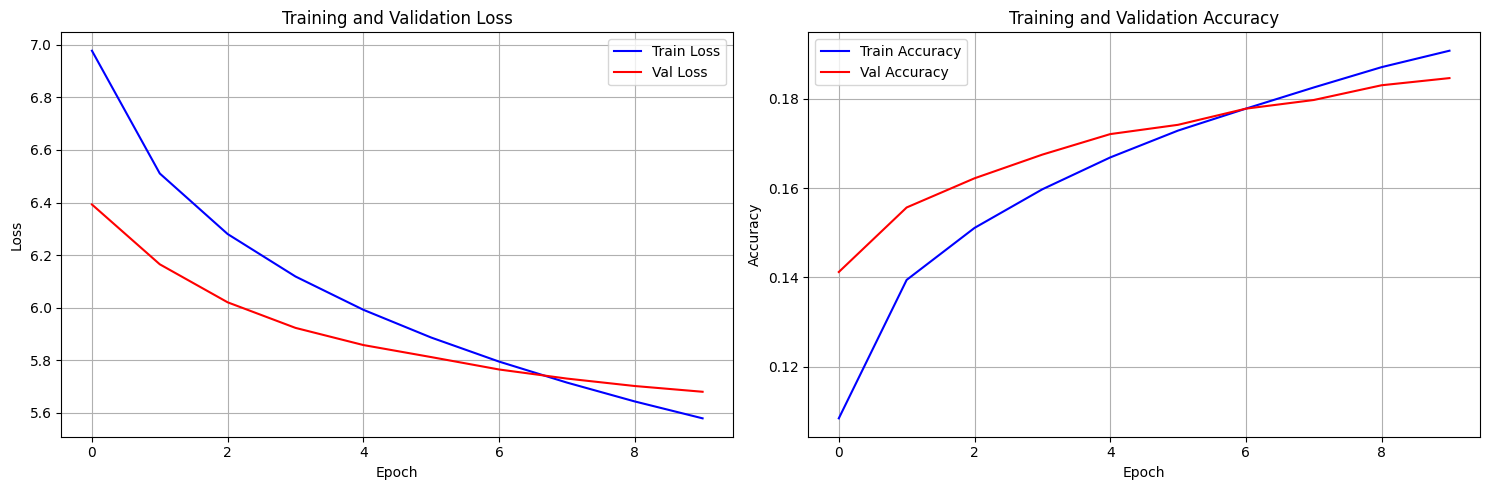


✅ Training completed!
📁 Model saved as 'gru_language_model.pth'
🎯 Final validation accuracy: 0.1846


In [4]:
# Train the GRU Language Model

import torch
import torch.nn as nn
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """Train the model for one epoch"""
    model.train()
    total_loss = 0
    total_samples = 0
    correct_predictions = 0
    
    # Progress bar
    pbar = tqdm(train_loader, desc=f'Epoch {epoch+1} Training')
    
    for batch_idx, (sequences, targets) in enumerate(pbar):
        # Move data to device
        sequences = sequences.to(device)
        targets = targets.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        logits, hidden = model(sequences)
        
        # Calculate loss (predict next token from last timestep)
        last_token_logits = logits[:, -1, :]  # [batch_size, vocab_size]
        loss = criterion(last_token_logits, targets)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        # May try 0.5 as the max_norm
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Statistics
        total_loss += loss.item()
        total_samples += targets.size(0)
        
        # Calculate accuracy
        predictions = torch.argmax(last_token_logits, dim=-1)
        correct_predictions += (predictions == targets).sum().item()
        
        # Update progress bar
        avg_loss = total_loss / (batch_idx + 1)
        accuracy = correct_predictions / total_samples
        pbar.set_postfix({
            'Loss': f'{avg_loss:.4f}',
            'Acc': f'{accuracy:.4f}'
        })
        
        # Print detailed stats every 1000 batches
        if (batch_idx + 1) % 1000 == 0:
            print(f'\nBatch {batch_idx+1}/{len(train_loader)}:')
            print(f'  Loss: {avg_loss:.4f}')
            print(f'  Accuracy: {accuracy:.4f}')
    
    avg_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy

def validate_epoch(model, val_loader, criterion, device, epoch):
    """Validate the model"""
    model.eval()
    total_loss = 0
    total_samples = 0
    correct_predictions = 0
    
    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f'Epoch {epoch+1} Validation')
        
        for sequences, targets in pbar:
            # Move data to device
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            # Forward pass
            logits, hidden = model(sequences)
            
            # Calculate loss
            last_token_logits = logits[:, -1, :]
            loss = criterion(last_token_logits, targets)
            
            # Statistics
            total_loss += loss.item()
            total_samples += targets.size(0)
            
            # Calculate accuracy
            predictions = torch.argmax(last_token_logits, dim=-1)
            correct_predictions += (predictions == targets).sum().item()
            
            # Update progress bar
            avg_loss = total_loss / len(val_loader) if len(val_loader) > 0 else 0
            accuracy = correct_predictions / total_samples
            pbar.set_postfix({
                'Val Loss': f'{avg_loss:.4f}',
                'Val Acc': f'{accuracy:.4f}'
            })
    
    avg_loss = total_loss / len(val_loader)
    accuracy = correct_predictions / total_samples
    
    return avg_loss, accuracy

def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=10):
    """Complete training loop"""
    
    # Training history
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []
    
    best_val_loss = float('inf')
    best_model_state = None
    
    print(f"Starting training for {num_epochs} epochs...")
    print(f"Training batches: {len(train_loader)}")
    print(f"Validation batches: {len(val_loader)}")
    print("-" * 60)
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        # Training
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, epoch)
        
        # Validation
        val_loss, val_acc = validate_epoch(model, val_loader, criterion, device, epoch)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print(f"✓ New best model saved! Val Loss: {val_loss:.4f}")
        
        # Record history
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Print epoch summary
        epoch_time = time.time() - epoch_start_time
        print(f"\nEpoch {epoch+1}/{num_epochs} Summary:")
        print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        print(f"  Time: {epoch_time:.2f}s")
        print("-" * 60)
    
    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f}s")
    print(f"Best validation loss: {best_val_loss:.4f}")
    
    # Load best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print("Loaded best model weights")
    
    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies,
        'best_val_loss': best_val_loss
    }

def plot_training_history(history):
    """Plot training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss plot
    ax1.plot(history['train_losses'], label='Train Loss', color='blue')
    ax1.plot(history['val_losses'], label='Val Loss', color='red')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Accuracy plot
    ax2.plot(history['train_accuracies'], label='Train Accuracy', color='blue')
    ax2.plot(history['val_accuracies'], label='Val Accuracy', color='red')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

# Start training
print("🚀 Starting GRU Language Model Training...")
print(f"Model has {sum(p.numel() for p in model.parameters()):,} parameters")

# Training parameters
# Try 20+ epochs, with LR-Scheduler
num_epochs = 10

# Train the model
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs
)

# Plot results
plot_training_history(history)

# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'vocab': vocab,
    'model_config': {
        'vocab_size': vocab_size,
        'embedding_dim': embedding_dim,
        'hidden_dim': hidden_dim,
        'num_layers': num_layers,
        'dropout': dropout
    }
}, 'gru_language_model.pth')

print("\n✅ Training completed!")
print("📁 Model saved as 'gru_language_model.pth'")
print(f"🎯 Final validation accuracy: {history['val_accuracies'][-1]:.4f}")

In [ ]:
# Test the trained model

# Text Generation and Next Word Prediction

import torch
import torch.nn.functional as F

def predict_next_word(model, input_text, vocab, idx_to_word, device, temperature=1.0, top_k=None):
    """
    Predict the next word given an input text
    
    Args:
        model: Trained GRU model
        input_text: Input sentence as string
        vocab: Vocabulary dictionary
        idx_to_word: Index to word mapping
        device: Device to run inference on
        temperature: Sampling temperature (higher = more random)
        top_k: If specified, only sample from top k most likely tokens
    
    Returns:
        predicted_word: The predicted next word
        probabilities: Top 10 word probabilities
    """
    model.eval()
    
    with torch.no_grad():
        # Tokenize input text
        tokens = basic_tokenize(input_text)
        if len(tokens) == 0:
            return "<unk>", []
        
        # Convert to indices
        indices = [vocab.get(token, vocab['<unk>']) for token in tokens]
        
        # Pad or truncate to sequence length (50)
        sequence_length = 50
        if len(indices) < sequence_length:
            # Pad with <pad> tokens at the beginning
            indices = [vocab['<pad>']] * (sequence_length - len(indices)) + indices
        else:
            # Take the last 50 tokens
            indices = indices[-sequence_length:]
        
        # Convert to tensor
        input_tensor = torch.tensor([indices], dtype=torch.long).to(device)  # [1, seq_len]
        
        # Forward pass
        logits, hidden = model(input_tensor)
        
        # Get logits for the last token
        last_logits = logits[0, -1, :]  # [vocab_size]
        
        # Apply temperature
        if temperature != 1.0:
            last_logits = last_logits / temperature
        
        # Apply top-k filtering if specified
        if top_k is not None:
            top_k = min(top_k, last_logits.size(-1))
            top_k_logits, top_k_indices = torch.topk(last_logits, top_k)
            # Set all other logits to negative infinity
            filtered_logits = torch.full_like(last_logits, float('-inf'))
            filtered_logits[top_k_indices] = top_k_logits
            last_logits = filtered_logits
        
        # Convert to probabilities
        probabilities = F.softmax(last_logits, dim=-1)
        
        # Get top 10 predictions for display
        top_probs, top_indices = torch.topk(probabilities, 10)
        top_words = [(idx_to_word[idx.item()], prob.item()) for idx, prob in zip(top_indices, top_probs)]
        
        # Sample from the distribution
        predicted_idx = torch.multinomial(probabilities, 1).item()
        predicted_word = idx_to_word[predicted_idx]
        
        return predicted_word, top_words

def generate_text(model, seed_text, vocab, idx_to_word, device, num_words=10, temperature=1.0, top_k=50):
    """
    Generate multiple words continuing from seed text
    
    Args:
        model: Trained GRU model
        seed_text: Starting text
        vocab: Vocabulary dictionary
        idx_to_word: Index to word mapping
        device: Device to run inference on
        num_words: Number of words to generate
        temperature: Sampling temperature
        top_k: Top-k sampling parameter
    
    Returns:
        generated_text: Complete generated text
    """
    model.eval()
    
    current_text = seed_text
    generated_words = []
    
    print(f"Seed text: '{seed_text}'")
    print("Generating words:")
    
    for i in range(num_words):
        predicted_word, top_words = predict_next_word(
            model, current_text, vocab, idx_to_word, device, temperature, top_k
        )
        
        # Skip special tokens
        if predicted_word in ['<unk>', '<pad>']:
            predicted_word = top_words[1][0] if len(top_words) > 1 else "the"
        
        generated_words.append(predicted_word)
        current_text += " " + predicted_word
        
        print(f"  {i+1}. {predicted_word} (top candidates: {[w[0] for w in top_words[:3]]})")
    
    generated_text = seed_text + " " + " ".join(generated_words)
    return generated_text

def interactive_prediction(model, vocab, idx_to_word, device):
    """
    Interactive mode for testing the model
    """
    print("\n🤖 Interactive Text Prediction Mode")
    print("Enter a sentence and I'll predict the next word!")
    print("Type 'quit' to exit, 'generate' to generate multiple words")
    print("-" * 60)
    
    while True:
        user_input = input("\nEnter text: ").strip()
        
        if user_input.lower() == 'quit':
            print("Goodbye! 👋")
            break
        
        if user_input.lower() == 'generate':
            seed_text = input("Enter seed text for generation: ").strip()
            if seed_text:
                num_words = int(input("How many words to generate? (default 10): ") or "10")
                temperature = float(input("Temperature (0.1-2.0, default 1.0): ") or "1.0")
                
                print(f"\n🎯 Generating {num_words} words...")
                generated = generate_text(model, seed_text, vocab, idx_to_word, device, 
                                        num_words=num_words, temperature=temperature, top_k=50)
                print(f"\n📝 Complete text: '{generated}'")
            continue
        
        if user_input:
            print(f"\n🔍 Analyzing: '{user_input}'")
            
            # Predict next word
            predicted_word, top_words = predict_next_word(
                model, user_input, vocab, idx_to_word, device, temperature=1.0, top_k=50
            )
            
            print(f"🎯 Predicted next word: '{predicted_word}'")
            print(f"\n📊 Top 10 candidates:")
            for i, (word, prob) in enumerate(top_words, 1):
                print(f"  {i:2d}. {word:<15} ({prob:.4f})")
            
            # Show the complete sentence
            complete_sentence = user_input + " " + predicted_word
            print(f"\n📝 Complete sentence: '{complete_sentence}'")

# Test the model with some examples
print("🧪 Testing the trained GRU model...")

# Example sentences to test
test_sentences = [
    "The cat sat on the",
    "I love to eat",
    "The weather today is",
    "Machine learning is",
    "In the future we will",
    "The president of the United",
    "Scientists have discovered a new",
    "The book was very"
]

print("\n📋 Testing with example sentences:")
print("=" * 60)

for i, sentence in enumerate(test_sentences, 1):
    print(f"\n{i}. Input: '{sentence}'")
    
    predicted_word, top_words = predict_next_word(
        model, sentence, vocab, idx_to_word, device, temperature=0.8, top_k=50
    )
    
    print(f"   Predicted: '{predicted_word}'")
    print(f"   Top 3: {[w[0] for w in top_words[:3]]}")
    print(f"   Complete: '{sentence} {predicted_word}'")

# Start interactive mode
interactive_prediction(model, vocab, idx_to_word, device)

🧪 Testing the trained GRU model...

📋 Testing with example sentences:

1. Input: 'The cat sat on the'
   Predicted: 'surface'
   Top 3: ['ground', 'unk', 'surface']
   Complete: 'The cat sat on the surface'

2. Input: 'I love to eat'
   Predicted: 'it'
   Top 3: ['the', 'unk', 'a']
   Complete: 'I love to eat it'

3. Input: 'The weather today is'
   Predicted: 'not'
   Top 3: ['a', 'the', 'also']
   Complete: 'The weather today is not'

4. Input: 'Machine learning is'
   Predicted: 'unk'
   Top 3: ['a', 'the', 'to']
   Complete: 'Machine learning is unk'

5. Input: 'In the future we will'
   Predicted: 'also'
   Top 3: ['be', 'not', 'have']
   Complete: 'In the future we will also'

6. Input: 'The president of the United'
   Predicted: 'states'
   Top 3: ['states', 'nations', 'kingdom']
   Complete: 'The president of the United states'

7. Input: 'Scientists have discovered a new'
   Predicted: 'front'
   Top 3: ['unk', 'rate', 'generation']
   Complete: 'Scientists have discovered a n


Enter text:  I'm living in the United



🔍 Analyzing: 'I'm living in the United'
🎯 Predicted next word: 'states'

📊 Top 10 candidates:
   1. states          (0.9700)
   2. kingdom         (0.0207)
   3. nations         (0.0015)
   4. notes           (0.0007)
   5. century         (0.0005)
   6. of              (0.0005)
   7. class           (0.0003)
   8. and             (0.0003)
   9. area            (0.0003)
  10. body            (0.0002)

📝 Complete sentence: 'I'm living in the United states'



Enter text:  Hello world! I am an AI, Who



🔍 Analyzing: 'Hello world! I am an AI, Who'
🎯 Predicted next word: 'can'

📊 Top 10 candidates:
   1. is              (0.2028)
   2. can             (0.1560)
   3. has             (0.0769)
   4. was             (0.0745)
   5. will            (0.0722)
   6. would           (0.0555)
   7. had             (0.0524)
   8. are             (0.0269)
   9. must            (0.0220)
  10. could           (0.0192)

📝 Complete sentence: 'Hello world! I am an AI, Who can'



Enter text:  Hello world! I am an AI, Who can save



🔍 Analyzing: 'Hello world! I am an AI, Who can save'
🎯 Predicted next word: 'on'

📊 Top 10 candidates:
   1. the             (0.2553)
   2. them            (0.1336)
   3. their           (0.0590)
   4. it              (0.0569)
   5. a               (0.0536)
   6. any             (0.0456)
   7. him             (0.0238)
   8. in              (0.0199)
   9. unk             (0.0173)
  10. for             (0.0163)

📝 Complete sentence: 'Hello world! I am an AI, Who can save on'



Enter text:  Hello world! I am an AI, Who can save o



🔍 Analyzing: 'Hello world! I am an AI, Who can save o'
🎯 Predicted next word: 'offer'

📊 Top 10 candidates:
   1. malley          (0.4640)
   2. brien           (0.1186)
   3. kong            (0.0807)
   4. acid            (0.0541)
   5. unk             (0.0349)
   6. acids           (0.0252)
   7. vegas           (0.0179)
   8. intelligence    (0.0147)
   9. márquez         (0.0140)
  10. shara           (0.0132)

📝 Complete sentence: 'Hello world! I am an AI, Who can save o offer'



Enter text:  Hello world! I am an AI, Who can save on



🔍 Analyzing: 'Hello world! I am an AI, Who can save on'
🎯 Predicted next word: 'an'

📊 Top 10 candidates:
   1. the             (0.3911)
   2. their           (0.0885)
   3. a               (0.0861)
   4. any             (0.0433)
   5. them            (0.0273)
   6. its             (0.0225)
   7. how             (0.0185)
   8. earth           (0.0175)
   9. unk             (0.0164)
  10. it              (0.0161)

📝 Complete sentence: 'Hello world! I am an AI, Who can save on an'



Enter text:  Hello world! I am an AI, Who can save on an



🔍 Analyzing: 'Hello world! I am an AI, Who can save on an'
🎯 Predicted next word: 'injury'

📊 Top 10 candidates:
   1. average         (0.1661)
   2. adult           (0.0491)
   3. air             (0.0469)
   4. alternative     (0.0424)
   5. hour            (0.0380)
   6. alien           (0.0378)
   7. unk             (0.0339)
   8. attempt         (0.0321)
   9. eye             (0.0292)
  10. emotional       (0.0270)

📝 Complete sentence: 'Hello world! I am an AI, Who can save on an injury'



Enter text:  Hundreds of thousands of



🔍 Analyzing: 'Hundreds of thousands of'
🎯 Predicted next word: 'aircraft'

📊 Top 10 candidates:
   1. men             (0.0865)
   2. aircraft        (0.0743)
   3. unk             (0.0587)
   4. dollars         (0.0540)
   5. water           (0.0515)
   6. people          (0.0484)
   7. women           (0.0411)
   8. thousands       (0.0338)
   9. equipment       (0.0296)
  10. birds           (0.0279)

📝 Complete sentence: 'Hundreds of thousands of aircraft'



Enter text:  Hundreds of thousands of aircraft



🔍 Analyzing: 'Hundreds of thousands of aircraft'
🎯 Predicted next word: 'aircraft'

📊 Top 10 candidates:
   1. and             (0.1315)
   2. are             (0.0874)
   3. in              (0.0748)
   4. were            (0.0634)
   5. from            (0.0377)
   6. per             (0.0353)
   7. the             (0.0328)
   8. with            (0.0317)
   9. can             (0.0263)
  10. including       (0.0249)

📝 Complete sentence: 'Hundreds of thousands of aircraft aircraft'



Enter text:  Hundreds of thousands of people



🔍 Analyzing: 'Hundreds of thousands of people'
🎯 Predicted next word: 'caused'

📊 Top 10 candidates:
   1. are             (0.1147)
   2. were            (0.1138)
   3. and             (0.1099)
   4. in              (0.1043)
   5. of              (0.0441)
   6. from            (0.0321)
   7. the             (0.0255)
   8. with            (0.0240)
   9. who             (0.0230)
  10. can             (0.0229)

📝 Complete sentence: 'Hundreds of thousands of people caused'



Enter text:  News, features and analysis from



🔍 Analyzing: 'News, features and analysis from'
🎯 Predicted next word: 'the'

📊 Top 10 candidates:
   1. the             (0.5477)
   2. a               (0.1049)
   3. their           (0.0521)
   4. its             (0.0361)
   5. other           (0.0278)
   6. unk             (0.0276)
   7. an              (0.0173)
   8. this            (0.0163)
   9. both            (0.0113)
  10. all             (0.0105)

📝 Complete sentence: 'News, features and analysis from the'



Enter text:  News, features and analysis from the



🔍 Analyzing: 'News, features and analysis from the'
🎯 Predicted next word: 'olympic'

📊 Top 10 candidates:
   1. unk             (0.1007)
   2. game            (0.0437)
   3. process         (0.0434)
   4. world           (0.0416)
   5. same            (0.0402)
   6. first           (0.0317)
   7. air             (0.0252)
   8. core            (0.0240)
   9. project         (0.0236)
  10. flight          (0.0234)

📝 Complete sentence: 'News, features and analysis from the olympic'



🔍 Analyzing: 'Hello, world! I am Archer. What is your'
🎯 Predicted next word: 'way'

📊 Top 10 candidates:
   1. unk             (0.3377)
   2. first           (0.1444)
   3. own             (0.0813)
   4. love            (0.0381)
   5. most            (0.0293)
   6. best            (0.0262)
   7. name            (0.0258)
   8. use             (0.0219)
   9. last            (0.0216)
  10. great           (0.0179)

📝 Complete sentence: 'Hello, world! I am Archer. What is your way'



Enter text:  He does not want to drink this



🔍 Analyzing: 'He does not want to drink this'
🎯 Predicted next word: 'time'

📊 Top 10 candidates:
   1. unk             (0.1353)
   2. with            (0.0529)
   3. to              (0.0496)
   4. as              (0.0481)
   5. in              (0.0475)
   6. work            (0.0421)
   7. use             (0.0342)
   8. other           (0.0289)
   9. name            (0.0271)
  10. time            (0.0265)

📝 Complete sentence: 'He does not want to drink this time'



Enter text:  He does not like this kind of 



🔍 Analyzing: 'He does not like this kind of'
🎯 Predicted next word: 'two'

📊 Top 10 candidates:
   1. the             (0.1570)
   2. their           (0.0626)
   3. a               (0.0570)
   4. his             (0.0422)
   5. unk             (0.0353)
   6. ireland         (0.0305)
   7. interest        (0.0260)
   8. all             (0.0240)
   9. each            (0.0233)
  10. those           (0.0233)

📝 Complete sentence: 'He does not like this kind of two'



Enter text:  Hello



🔍 Analyzing: 'Hello'
🎯 Predicted next word: 'and'

📊 Top 10 candidates:
   1. unk             (0.3862)
   2. and             (0.3561)
   3. the             (0.0491)
   4. in              (0.0238)
   5. were            (0.0133)
   6. which           (0.0103)
   7. of              (0.0087)
   8. university      (0.0077)
   9. a               (0.0076)
  10. who             (0.0076)

📝 Complete sentence: 'Hello and'



Enter text:  How are



🔍 Analyzing: 'How are'
🎯 Predicted next word: 'found'

📊 Top 10 candidates:
   1. also            (0.0793)
   2. the             (0.0764)
   3. a               (0.0539)
   4. not             (0.0448)
   5. one             (0.0417)
   6. used            (0.0397)
   7. unk             (0.0294)
   8. made            (0.0287)
   9. called          (0.0266)
  10. in              (0.0251)

📝 Complete sentence: 'How are found'



Enter text:  How are you, fine



🔍 Analyzing: 'How are you, fine'
🎯 Predicted next word: 'and'

📊 Top 10 candidates:
   1. and             (0.6350)
   2. unk             (0.1204)
   3. the             (0.0433)
   4. in              (0.0298)
   5. with            (0.0241)
   6. as              (0.0140)
   7. to              (0.0128)
   8. for             (0.0088)
   9. or              (0.0087)
  10. life            (0.0059)

📝 Complete sentence: 'How are you, fine and'



Enter text:  How are you, find and



🔍 Analyzing: 'How are you, find and'
🎯 Predicted next word: 'unk'

📊 Top 10 candidates:
   1. the             (0.1755)
   2. a               (0.0967)
   3. unk             (0.0864)
   4. that            (0.0842)
   5. as              (0.0489)
   6. their           (0.0350)
   7. by              (0.0348)
   8. in              (0.0306)
   9. for             (0.0229)
  10. to              (0.0229)

📝 Complete sentence: 'How are you, find and unk'



Enter text:  How are you, fine and



🔍 Analyzing: 'How are you, fine and'
🎯 Predicted next word: 'the'

📊 Top 10 candidates:
   1. unk             (0.3697)
   2. the             (0.2034)
   3. other           (0.0370)
   4. a               (0.0316)
   5. was             (0.0235)
   6. is              (0.0154)
   7. and             (0.0153)
   8. others          (0.0151)
   9. in              (0.0133)
  10. it              (0.0130)

📝 Complete sentence: 'How are you, fine and the'



Enter text:  How are you, find and thank



🔍 Analyzing: 'How are you, find and thank'
🎯 Predicted next word: 'when'

📊 Top 10 candidates:
   1. the             (0.1869)
   2. by              (0.1784)
   3. for             (0.0763)
   4. a               (0.0529)
   5. unk             (0.0462)
   6. and             (0.0384)
   7. in              (0.0366)
   8. as              (0.0358)
   9. to              (0.0271)
  10. that            (0.0182)

📝 Complete sentence: 'How are you, find and thank when'



Enter text:  How are you, fine and thank



🔍 Analyzing: 'How are you, fine and thank'
🎯 Predicted next word: 'richard'

📊 Top 10 candidates:
   1. by              (0.1482)
   2. the             (0.1446)
   3. unk             (0.1255)
   4. for             (0.0554)
   5. and             (0.0469)
   6. a               (0.0303)
   7. in              (0.0259)
   8. john            (0.0249)
   9. it              (0.0236)
  10. as              (0.0173)

📝 Complete sentence: 'How are you, fine and thank richard'



Enter text:  How are you, fine and thank you.



🔍 Analyzing: 'How are you, fine and thank you.'
🎯 Predicted next word: 'think'

📊 Top 10 candidates:
   1. have            (0.1389)
   2. are             (0.0899)
   3. and             (0.0662)
   4. unk             (0.0654)
   5. re              (0.0547)
   6. were            (0.0524)
   7. to              (0.0382)
   8. was             (0.0378)
   9. can             (0.0375)
  10. had             (0.0271)

📝 Complete sentence: 'How are you, fine and thank you. think'
